## Импорт и установка библиотек

Создайте окружение и установите туда зависимости

In [1]:
!pip install -r requirements.txt

  Using cached fqdn-1.5.1-py3-none-any.whl.metadata (1.4 kB)
  Using cached isoduration-20.11.0-py3-none-any.whl.metadata (5.7 kB)
  Using cached uri_template-1.3.0-py3-none-any.whl.metadata (8.8 kB)
  Using cached webcolors-24.6.0-py3-none-any.whl.metadata (2.6 kB)
Using cached webcolors-24.6.0-py3-none-any.whl (14 kB)
Using cached fqdn-1.5.1-py3-none-any.whl (9.1 kB)
Using cached isoduration-20.11.0-py3-none-any.whl (11 kB)
Using cached uri_template-1.3.0-py3-none-any.whl (11 kB)


Скачайте веса для stylegan2 1024х1024 https://drive.google.com/file/d/1igxv6ZP4TFGe_392B-qnSqXnglTKH5yo/view?usp=drive_link

Также скачайте веса для ArcFace модели https://drive.google.com/file/d/1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn/view

Все веса должны лежать в одной директории с данным ноутбуком

In [1]:
!git clone https://github.com/rosinality/stylegan2-pytorch.git

fatal: destination path 'stylegan2-pytorch' already exists and is not an empty directory.


In [1]:
!git clone https://github.com/omertov/encoder4editing.git

Cloning into 'encoder4editing'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 172 (delta 49), reused 42 (delta 42), pack-reused 94
Receiving objects: 100% (172/172), 33.43 MiB | 1.26 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-21ee6bi0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-21ee6bi0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.2.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached torch-2.3.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.18.1-cp310-cp310-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached wcwidth-0.2.13-py2.py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metad

In [3]:
import os

import sys
sys.path.insert(0, 'stylegan2-pytorch/')
sys.path.insert(1, "encoder4editing")

import math

from tqdm import tqdm

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from torchvision import utils

from PIL import Image


# Костыль начало
with open("stylegan2-pytorch/lpips/__init__.py", "r") as file:
  lines = file.readlines()

lines[6] = 'from skimage.metrics import structural_similarity\n'

lines[52] = lines[52].replace('compare_ssim', 'structural_similarity')

with open("stylegan2-pytorch/lpips/__init__.py", 'w') as file:
    file.writelines(lines)
# Костыль конец

# change library import in lpips __init__.py  'from skimage.measure import compare_ssim' to 'from skimage.metrics import structural_similarity'
# Edit line 53 'compare_ssim' to 'structural_similarity', keep parameters as is.
import lpips

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

## Инициализация модели
Генератор StyleGAN2

In [12]:
from model import Generator

truncation = 1
truncation_mean = 4096

sample_size=1

img_size = 1024
style_dim = 512
n_mlp = 8
channel_multiplier = 2

g_model = Generator(
    size=img_size,
    style_dim=style_dim,
    n_mlp=n_mlp,
    channel_multiplier=channel_multiplier
).to(device).eval()

g_model.load_state_dict(torch.load("stylegan2-ffhq-config-f.pt")["g_ema"], strict=False)

mean_latent = g_model.mean_latent(truncation_mean)

ArcFace модель

In [13]:
from encoder4editing.models.encoders.model_irse import Backbone

arcface_model = Backbone(input_size=112, num_layers=50, drop_ratio=0.5, mode="ir_se")
arcface_model.load_state_dict(torch.load("model_ir_se50.pth"))
arcface_model.to(device)
arcface_model.eval();

### Генерация изображений

In [31]:
def gen_and_save_imgs(n_imgs):
  latent_init_list = []

  for i in range(n_imgs):

    with torch.no_grad():
      g_model.eval()

      sample_z = torch.randn(sample_size, style_dim, device=device)

      sample, latent_code_init = g_model(
          [sample_z],
          return_latents=True,
          truncation=truncation,
          truncation_latent=mean_latent
      )

      utils.save_image(
                      sample,
                      f"{str(i).zfill(6)}.png",
                      nrow=1,
                      normalize=True,
                      value_range=(-1, 1),
                  )

      latent_init_list.append(latent_code_init)

  return latent_init_list

In [33]:
def get_lr(t, initial_lr, rampdown=0.50, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

In [10]:
import clip

class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=32)

    def forward(self, image, text):
        image = self.upsample(image)
        image = self.avg_pool(image)
        image_text = self.model(image, text)
        similarity = 1 - image_text[0] / 100

        return similarity

In [35]:
def get_arcface_img(vec):

    transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    vec_img, _ = g_model(
          [vec],
          return_latents=True,
          truncation=truncation,
          truncation_latent=mean_latent
    )

    vec_img = vec_img.cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
    vec_img = ((vec_img + 1) / 2 * 255).astype(np.uint8)

    vec_img = Image.fromarray(vec_img)

    vec_img = transform(vec_img).unsqueeze(0)

    return vec_img

## Оптимизация

In [36]:
def optimize(g_model, w_s, prompt, l2_lambda, id_lambda, lr=0.1, n_steps=100, checkpoint_steps=10):
  text_vec = torch.cat([clip.tokenize(prompt)]).cuda()

  w = w_s.detach().clone()
  w.requires_grad = True

  clip_loss = CLIPLoss()
  optimizer = optim.Adam([w], lr=lr)

  os.makedirs(results_dir, exist_ok=True)

  pbar = tqdm(range(n_steps))

  lr_history = []

  for i in pbar:

    optimizer.zero_grad()

    t = i / n_steps

    curr_lr = get_lr(t, lr)
    optimizer.param_groups[0]["lr"] = curr_lr

    img_gen, _ = g_model([w], input_is_latent=True, randomize_noise=False)

    w_s_img = get_arcface_img(w_s).to(device)
    w_img = get_arcface_img(w).to(device)

    with torch.no_grad():
        w_s_features = arcface_model(w_s_img)
        w_features = arcface_model(w_img)


    id_loss = 1 - F.cosine_similarity(w_s_features, w_features).mean()
    c_loss = clip_loss(img_gen, text_vec)
    l2_loss = ((w_s - w) ** 2).sum()

    loss = c_loss + l2_loss*l2_lambda + id_loss*id_lambda

    loss.backward()
    optimizer.step()

    pbar.set_description(f"lr: {curr_lr:.4f}, loss: {loss.item():.4f}")

    lr_history.append(curr_lr)

    if i % checkpoint_steps == 0:

      with torch.no_grad():
        img_gen, _ = g_model([w], input_is_latent=True, randomize_noise=False)

      torchvision.utils.save_image(img_gen,f"results/{str(i).zfill(5)}.jpg",
                                     normalize=True, value_range=(-1, 1))

  with torch.no_grad():
    img_orig, _ = g_model([w_s],
                           input_is_latent=True,
                           randomize_noise=False)

  final_result = torch.cat([img_orig, img_gen])

  torchvision.utils.save_image(final_result.detach().cpu(),
                              "results/final_result.jpg",
                              normalize=True, scale_each=True, value_range=(-1, 1))

In [32]:
latent_init_list = gen_and_save_imgs(3)

In [80]:
prompt = "Young boy with red hair and smile face"
lr_rampup = 0.05
lr = 0.05
n_steps = 100
l2_lambda = 0.01
id_lambda = 0.005

checkpoint_steps = 10
results_dir = 'results'

optimize(
    g_model=g_model,
    w_s=latent_init_list[0],
    prompt=prompt,
    l2_lambda=l2_lambda,
    id_lambda=id_lambda,
    n_steps=n_steps
)

lr: 0.0001, loss: 0.6733: 100%|██████████| 100/100 [00:51<00:00,  1.96it/s]


## Инверсия GAN

### Вспомогательные функции

In [81]:
def noise_regularize(noises):
    loss = 0

    for noise in noises:
        size = noise.shape[2]

        while True:
            loss = (
                loss
                + (noise * torch.roll(noise, shifts=1, dims=3)).mean().pow(2)
                + (noise * torch.roll(noise, shifts=1, dims=2)).mean().pow(2)
            )

            if size <= 8:
                break

            noise = noise.reshape([-1, 1, size // 2, 2, size // 2, 2])
            noise = noise.mean([3, 5])
            size //= 2

    return loss


def noise_normalize_(noises):
    for noise in noises:
        mean = noise.mean()
        std = noise.std()

        noise.data.add_(-mean).div_(std)


def latent_noise(latent, strength):
    noise = torch.randn_like(latent) * strength

    return latent + noise


def make_image(tensor):
    return (
        tensor.detach()
        .clamp_(min=-1, max=1)
        .add(1)
        .div_(2)
        .mul(255)
        .type(torch.uint8)
        .permute(0, 2, 3, 1)
        .to("cpu")
        .numpy()
    )

In [102]:
def latent_reverse(invert_image_path, img_size=1024, invert_lr=0.1, invert_steps=500, checkpoint_steps=100):
  n_mean_latent = 10000
  target_img = mpimg.imread(invert_image_path)
  noise_value = 0.05
  noise_ramp = 0.75
  noise_regularize_value = 1e5
  MSE = 0
  z_history = []

  transform = transforms.Compose(
      [
          transforms.Resize(img_size),
          transforms.ToTensor(),
          transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
      ]
  )

  img = transform(Image.open(invert_image_path).convert("RGB")).to(device)
  img = img.unsqueeze(0)
  g_model.eval()

  with torch.no_grad():
    noise_sample = torch.randn(n_mean_latent, 512, device=device) # Z noise

    latent_out = g_model.style(noise_sample)

    latent_mean = latent_out.mean(0)
    latent_std = ((latent_out - latent_mean).pow(2).sum() / n_mean_latent) ** 0.5

  # percept = lpips.LPIPS(net="vgg").to(device)

  percept = lpips.PerceptualLoss(
      model="net-lin", net="vgg", use_gpu=True
  )


  noises_single = g_model.make_noise()

  noises = []
  for noise in noises_single:
    noises.append(noise.repeat(img.shape[0], 1, 1, 1).normal_())

  latent_in = latent_mean.detach().clone().unsqueeze(0).repeat(img.shape[0], 1)

  latent_in.requires_grad = True

  for noise in noises:
      noise.requires_grad = True

  optimizer = optim.Adam([latent_in] + noises, lr=invert_lr)

  pbar = tqdm(range(invert_steps))

  latent_path = []

  for i in pbar:
      t = i / invert_steps
      lr = get_lr(t, invert_lr)
      optimizer.param_groups[0]["lr"] = lr

      noise_strength = latent_std * noise_value * max(0, 1 - t / noise_ramp) ** 2
      latent_n = latent_noise(latent_in, noise_strength.item())
      img_gen, z_latent = g_model([latent_n], input_is_latent=True, noise=noises, return_latents=True)

      batch, channel, height, width = img_gen.shape

      p_loss = percept(img_gen, img).sum()
      n_loss = noise_regularize(noises)
      mse_loss = F.mse_loss(img_gen, img)

      loss = p_loss + noise_regularize_value*n_loss + MSE*mse_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      noise_normalize_(noises)

      if (i + 1) % checkpoint_steps == 0:
          curr_img = make_image(img_gen)[0]
          latent_path.append(latent_in.detach().clone())
          z_history.append(z_latent)

          fig, ax = plt.subplots(1,2, figsize=(10,5))
          ax[0].set_title("Generated")
          ax[1].set_title("Target")
          ax[0].imshow(curr_img)
          ax[1].imshow(target_img)
          plt.show()

      pbar.set_description(
          (
              f"perceptual: {p_loss.item():.4f}; noise regularize: {n_loss.item():.4f};"
              f" mse: {mse_loss.item():.4f}; lr: {lr:.4f}"
          )
      )
  img_gen, _ = g_model([latent_path[-1]], input_is_latent=True, noise=noises)

  img_ar = make_image(img_gen)

  torchvision.utils.save_image(img_gen,
                               "final_invert_result.jpg",
                               normalize=True, scale_each=True, value_range=(-1, 1))

  return img_ar, latent_path, z_history


Setting up Perceptual loss...
Loading model from: /content/stylegan2-pytorch/lpips/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


perceptual: 0.4433; noise regularize: 0.0001; mse: 0.0381; lr: 0.2000:  33%|███▎      | 99/300 [01:12<02:23,  1.40it/s]

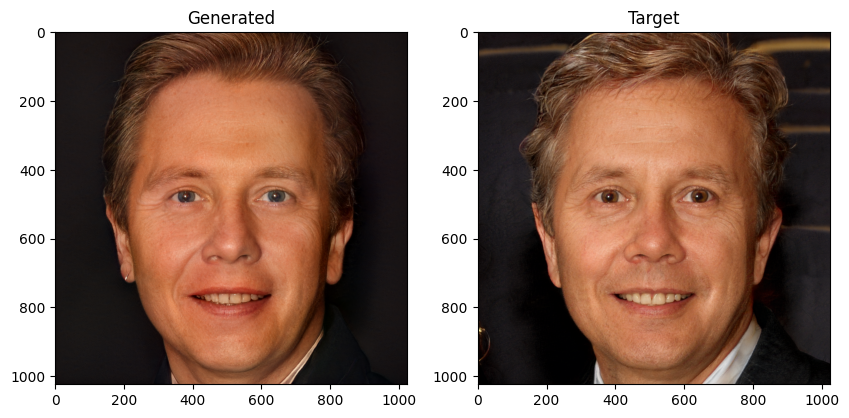

perceptual: 0.3962; noise regularize: 0.0000; mse: 0.0250; lr: 0.1536:  66%|██████▋   | 199/300 [02:24<01:12,  1.39it/s]

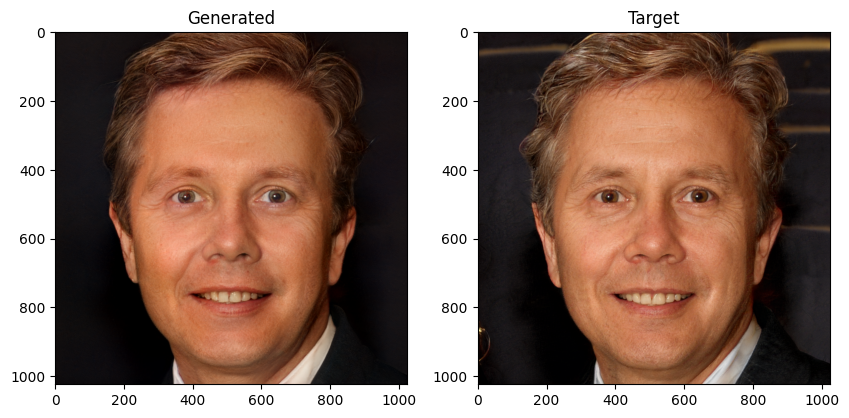

perceptual: 0.3671; noise regularize: 0.0000; mse: 0.0180; lr: 0.0001: 100%|█████████▉| 299/300 [03:37<00:00,  1.39it/s]

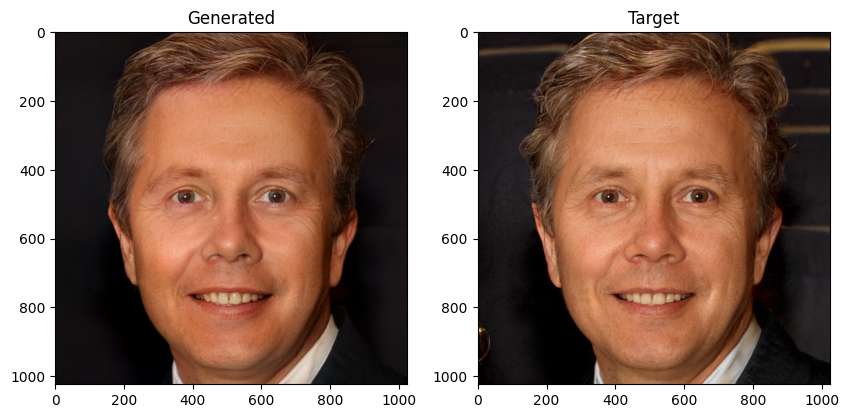

perceptual: 0.3671; noise regularize: 0.0000; mse: 0.0180; lr: 0.0000: 100%|██████████| 300/300 [03:39<00:00,  1.37it/s]


In [104]:
invert_image_path = '000000.png'
invert_steps = 300
arr, w_history, z_history = latent_reverse(invert_image_path=invert_image_path,
                                                   invert_steps=invert_steps,
                                                   invert_lr=0.2,
                                                   checkpoint_steps=100)

In [ ]:
rev_w_s = w_history[-1]

In [ ]:
optimize(
    g_model=g_model,
    w_s=rev_w_s,
    prompt="A blue hair",
)